In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt
%matplotlib inline


from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d

def pandasd_savgol(series:pd.Series, window_length, polyorder)->pd.Series:
    data = savgol_filter(series.values, window_length, polyorder)
    return pd.Series(data = data, index = series.index)
def pandas_gradient(series:pd.Series, strike_level = -1)->pd.Series:
    price = series.values
    strikes = series.index.get_level_values(strike_level)
    data = np.gradient(price)/np.gradient(strikes)
    return pd.Series(data=data, index = series.index)

idx = pd.IndexSlice
sns.set_style('whitegrid')
sns.set_palette('tab10')

# Data cleaning

In [5]:
options_import = pd.read_csv('~/kaggle-data/jpx-stock-exchange-prediction/train_files/options.csv')
# options_import.to_json()
# import pickle
# with open('options_data', 'wb') as f:
#     pickle.dump(options_import.to_json(), f)

/tmp/ipykernel_363650/2040848363.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv('~/kaggle-data/jpx-stock-exchange-prediction/train_files/options.csv')


In [6]:
options_import['Date'] = pd.to_datetime(options_import['Date'])

options_import['Expiry'] =options_import.LastTradingDay.astype(str)
options_import['Expiry'] = pd.to_datetime(options_import['Expiry'], format = '%Y%m%d')


options =options_import.set_index(['Date','Expiry', 'Putcall',  'StrikePrice']).sort_index()

options = options[[ 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'WholeDayVolume',
       'LastTradingDay', 'SpecialQuotationDay', 'SettlementPrice',
       'TheoreticalPrice', 'BaseVolatility', 'ImpliedVolatility',
       'InterestRate', 'DividendRate', 'Dividend']]

options = options[options.WholeDayVolume>0]

In [3]:
# Useful groupby indices
indices = ['Date','Expiry', 'Putcall', ]
# A list of all the contracts in my dataset
contract_list = pd.DataFrame()

#aggregated trading volume (over all possible strikes) at a specific contract
contract_list['TotalVolume'] = options.groupby(indices)[['WholeDayVolume']].sum()

#Number of strike prices in a contract
contract_list['N_strikes']=options.reset_index('StrikePrice').groupby(indices)['StrikePrice'].nunique()


N_strikes = options.index.get_level_values('StrikePrice').unique().__len__()

# Filter contracts such that the whole day trading volume is greater than the number of strikes
contract_list = contract_list[contract_list.TotalVolume>1*N_strikes]

#rank the contracts by their volumes
contract_list['VolumeRank'] = contract_list['TotalVolume'].rank(ascending=False)
contract_list.sort_values(by = 'VolumeRank', inplace = True)


In [4]:
import pandas as pd

# Create a sample pandas Series
data = {'values': [10, 15, 20, 10, 5]}
series = pd.Series(data['values'])

# Create a DataFrame with original, shifted values, and first derivative
df = pd.DataFrame({'Original': series,
                   'Shifted(-1)': series.shift(-1),
                   'Shifted(1)': series.shift(1)})

# Calculate the first derivative and add it as a new column
df['First Derivative'] = (df['Shifted(-1)'] - df['Shifted(1)']) 
df['Second Derivative'] = df['Shifted(1)'] + df['Shifted(-1)'] - 2 * df['Original']
print(df)

   Original  Shifted(-1)  Shifted(1)  First Derivative  Second Derivative
0        10         15.0         NaN               NaN                NaN
1        15         20.0        10.0              10.0                0.0
2        20         10.0        15.0              -5.0              -15.0
3        10          5.0        20.0             -15.0                5.0
4         5          NaN        10.0               NaN                NaN


In [5]:
def pd_GaussKernelSmoother(series:pd.Series, sigma=3, order = 0)->pd.Series:
    smoothed = gaussian_filter1d(series.dropna(), sigma, order)
    smoothed_series = pd.Series(index = series.index)
    smoothed_series[series.isna()] = np.nan
    smoothed_series[~series.isna()] = smoothed
    return smoothed_series

# def pandas_butterfly_contract(series:pd.Series, put_indicator = 1, call_indicator = 2)->pd.Series:
    # return series.shift(1)+series.shift(-1)-2*series



In [6]:
# 3 methods to calculate butterfly spread

# Less than 0.1s runtime 
def pandas_butterfly_contract(obj = pd.core.groupby.generic.SeriesGroupBy) -> pd.Series:
    return obj.shift(1)+obj.shift(-1) -2*obj.shift(0)
options['butterfly'] = pandas_butterfly_contract(options['WholeDayClose'].groupby(indices, group_keys=False))

#4.4 seconds runtime
#options.groupby(indices, group_keys=False)['WholeDayClose'].apply(pandas_butterfly_contract)

#4.4 seconds runtime
# options.groupby(indices, group_keys=False)['WholeDayClose'].apply(lambda x: x.shift(1)+x.shift(-1)-2*x)

# calculate the derivative
options['dK'] = options.index.get_level_values('StrikePrice')
options['dK'] = options['dK'].groupby(['Date', 'Expiry', 'Putcall']).diff()
options['curvature'] = options.butterfly.div(options.dK.pow(2))

In [7]:
options['pdf'] = options.groupby(indices, group_keys=False)['curvature'].apply(
    pd_GaussKernelSmoother, 14)

(Timestamp('2018-02-07 00:00:00'), Timestamp('2018-02-08 00:00:00'), 1)
1.6


<Axes: xlabel='StrikePrice', ylabel='curvature'>

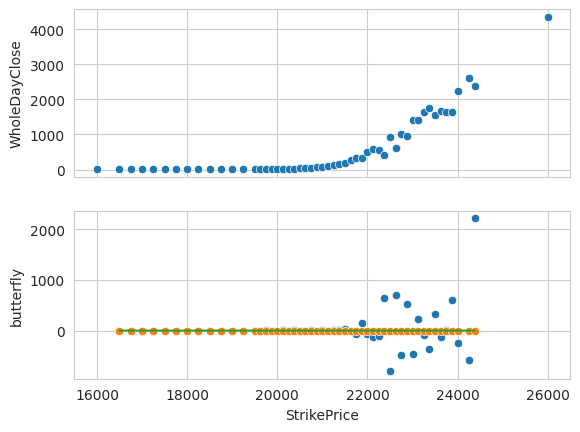

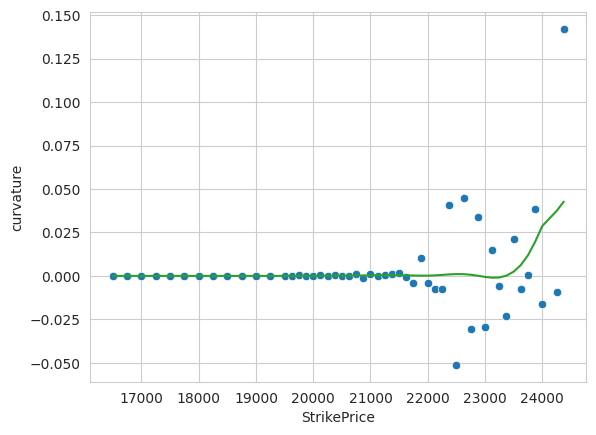

In [8]:
example_1 = contract_list.index[3]
print(example_1)
df_orig = options.loc[example_1]

df=df_orig.copy()

# df = df_orig[df_orig.butterfly >df_orig.butterfly.mean()-1*df_orig.butterfly.std()*3]
# df = df_orig.iloc[:-4]
# df = df[df.WholeDayVolume > df.WholeDayVolume.quantile(0.05)]
# df['implied_pdf'] = gaussian_filter1d(df['curvature'], sigma =1, order = 0)
# df['implied_pdf'] = gaussian_filter1d(df.curvature.dropna(), sigma = 3, order =0)
# df = df_orig[df_orig.WholeDayVolume>df_orig.WholeDayVolume.quantile(0.05)]

print(df_orig.WholeDayVolume.quantile(0.05))
df['implied_pdf'] = pd_GaussKernelSmoother(df.curvature, 2.5, order = 0)
fig, ax = plt.subplots(2, 1, figsize = (6.4, 4.8), sharex=True)

sns.scatterplot(df_orig, x = 'StrikePrice', y = 'WholeDayClose', ax=ax[0])
sns.scatterplot(df, x = 'StrikePrice', y = 'butterfly', ax=ax[1])
sns.scatterplot(df, x = 'StrikePrice', y = 'pdf', ax=ax[1])
sns.lineplot(df, x = 'StrikePrice', y = 'implied_pdf', ax=ax[1], color = 'tab:green')

fig,ax = plt.subplots()
# sns.scatterplot(df, x = 'StrikePrice', y = 'pdf', )
sns.scatterplot(df, x = 'StrikePrice', y = 'curvature', )
sns.lineplot(df, x = 'StrikePrice', y = 'implied_pdf', color = 'tab:green')

0.003042196078431373

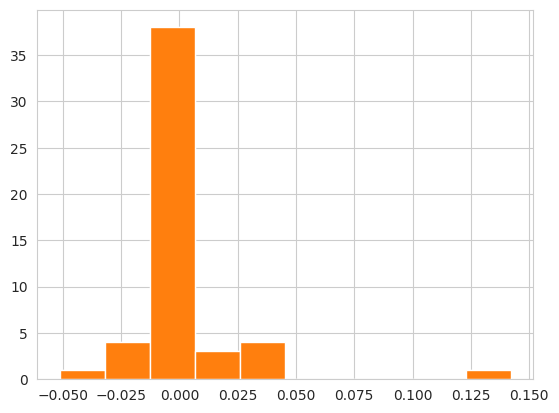

In [9]:
df_orig.curvature.hist()
df.curvature.hist()
df.curvature.std()
df.curvature.mean()

<Axes: xlabel='StrikePrice'>

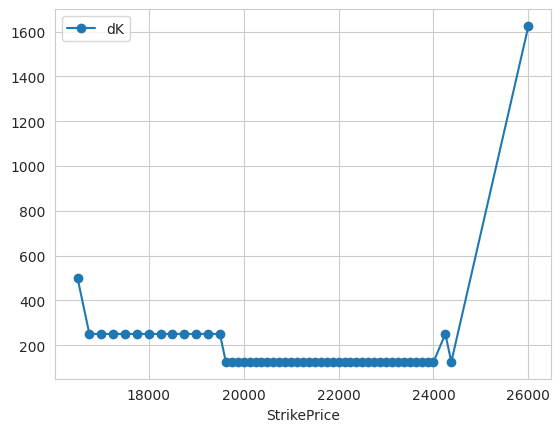

In [10]:
df[['dK']].plot(marker ='o')

In [11]:
options.pdf

Date        Expiry      Putcall  StrikePrice
2017-01-04  2017-01-12  1        13000.0             NaN
                                 14500.0        0.000016
                                 14625.0        0.000016
                                 14750.0        0.000017
                                 14875.0        0.000019
                                                  ...   
2021-12-03  2022-06-09  2        29000.0             NaN
            2022-09-08  1        25000.0             NaN
                                 25500.0       -0.000480
                                 25750.0             NaN
            2022-12-08  1        7000.0              NaN
Name: pdf, Length: 322687, dtype: float64